In [ ]:
# Install required packages
! pip install opencv-python
! pip install numpy
! pip install tensorflow
! pip install pytorch
! pip install PyQt5
! pip install PyQt5-tools
! pip install matplotlib
! pip install pandas
! pip install scikit-learn
! pip install albumentations


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
from config import Config

class Config:
    # Model parameters
    MODEL_PATH = 'models/'
    INPUT_SIZE = (416, 416)  
    
    # Dataset parameters
    TRAIN_PATH = 'data/train/'
    TEST_PATH = 'data/test/'
    VAL_PATH = 'data/val/'
    
    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 100
    LEARNING_RATE = 0.001

    # Augmentation parameters
    AUGUMENT_TRAIN = True
    AUGUMENT_VAL = False

    # Class names
    CLASSES = [
        'Automatic Rifle', 'Bazooka', 'Grenade Launcher', 
        'Handgun', 'Knife', 'SMG', 'Shotgun', 'Sniper', 'Sword'
    ]

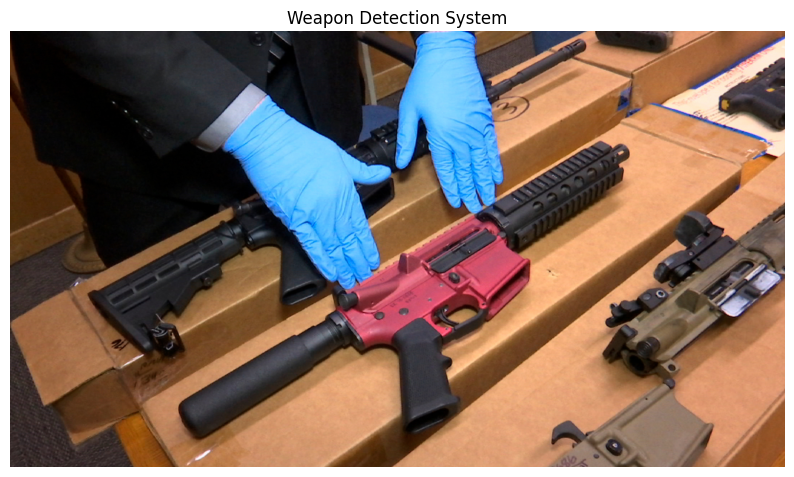

In [3]:
def load_image(image_path):
    """Load and preprocess image"""
    img = cv2.imread(image_path)
    if img is None:
        raise IOError(f"Cannot open image at {image_path}")
    # Convert BGR to RGB for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image, title='Weapon Detection System'):
    """Display image using matplotlib"""
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def main():
    try:
        # Load and display static image
        image_path = "image.png"  # Replace with your image path
        image = load_image(image_path)
        
        # Display using matplotlib
        display_image(image)
                
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

In [4]:


from albumentations import (
    Compose, RandomBrightnessContrast,
    HorizontalFlip, VerticalFlip, Rotate,
    Blur, CLAHE, RandomShadow, RandomFog, ShiftScaleRotate, ColorJitter
)

def load_and_preprocess_image(image_path, target_size=(416, 416)):
    """Load and preprocess a single image"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise IOError(f"Cannot open image at {image_path}")
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype('float32') / 255.0
    
    return img

def get_augmentation():
    """Enhanced augmentation pipeline"""
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.3),
        Rotate(limit=45, p=0.3),
        RandomBrightnessContrast(p=0.4),
        Blur(blur_limit=3, p=0.2),
        CLAHE(p=0.3),
        RandomShadow(p=0.2),
        RandomFog(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.3),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3)
    ])

def process_batch(images, batch_size=32, augment=True):
    """Process images in batches"""
    aug = get_augmentation() if augment else None
    n_samples = len(images)
    
    for start_idx in range(0, n_samples, batch_size):
        batch_images = []
        end_idx = min(start_idx + batch_size, n_samples)
        
        for idx in range(start_idx, end_idx):
            img = load_and_preprocess_image(images[idx])
            if aug:
                augmented = aug(image=img)
                img = augmented['image']
            batch_images.append(img)
            
        yield np.array(batch_images)

def visualize_augmentations(image_path, num_samples=5):
    """Visualize different augmentations of a single image"""
    original = load_and_preprocess_image(image_path)
    aug = get_augmentation()
    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')
    
    for i in range(num_samples):
        augmented = aug(image=original)['image']
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(augmented)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_batch(batch_images, labels=None):
    """Visualize a batch of images"""
    batch_size = len(batch_images)
    cols = min(batch_size, 8)
    rows = (batch_size + cols - 1) // cols
    
    plt.figure(figsize=(15, 2*rows))
    for i, img in enumerate(batch_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        if labels is not None:
            plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def prepare_dataset(dataset_path, batch_size=32, augment=True):
    """Prepare dataset with batching and augmentation"""
    images = []
    labels = []
    
    # Get list of image files
    image_files = [f for f in os.listdir(dataset_path) 
                  if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process images in batches
    for batch in process_batch([os.path.join(dataset_path, f) for f in image_files], 
                             batch_size=batch_size, 
                             augment=augment):
        images.extend(batch)
        # Extract labels from filenames
        batch_labels = [f.split('_')[0] for f in image_files]
        labels.extend(batch_labels)
    
    return np.array(images), np.array(labels)

c:\Users\Idris\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()


✅ Image loading and preprocessing: Success


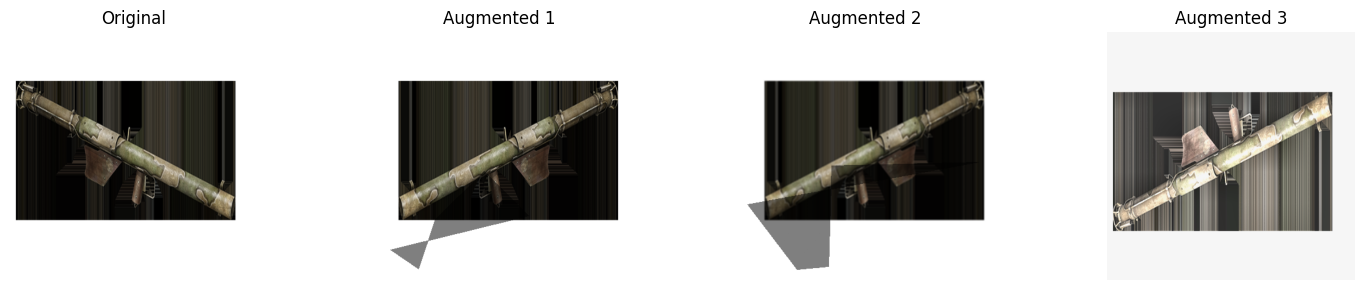

✅ Augmentation pipeline: Success
✅ Batch processing: Success
Dataset shape: (571, 416, 416, 3)
Labels shape: (81653,)


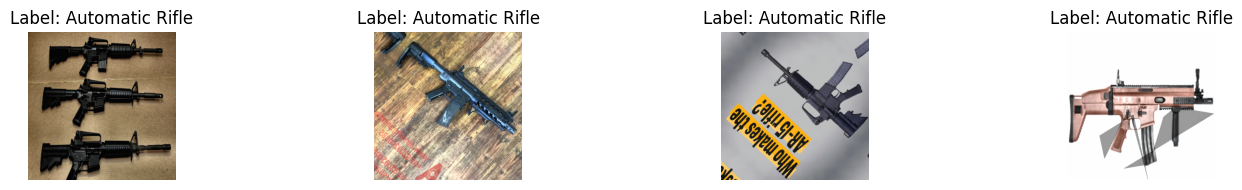

✅ Visualization: Success


In [5]:
# Add this to a new cell


def test_pipeline():
    # Test image loading and preprocessing
    try:
        # Replace with your test image path
        test_image_path = "data/test/Bazooka_11.png"
        
        # Test single image processing
        processed_img = load_and_preprocess_image(test_image_path)
        print("✅ Image loading and preprocessing: Success")
        
        # Test augmentation
        visualize_augmentations(test_image_path, num_samples=3)
        print("✅ Augmentation pipeline: Success")
        
        # Test batch processing
        test_dataset_path = "data/test"  # Replace with your dataset path
        images, labels = prepare_dataset(test_dataset_path, batch_size=4, augment=True)
        print("✅ Batch processing: Success")
        print(f"Dataset shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        
        # Visualize a batch
        visualize_batch(images[:4], labels[:4])
        print("✅ Visualization: Success")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Run the test
test_pipeline()

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2  # Efficient for real-time detection
from config import Config

def create_model(input_shape=(416, 416, 3), num_classes=2):
    """
    Create a CNN model for weapon detection using transfer learning with MobileNetV2
    """
    # Base model - MobileNetV2 (pre-trained on ImageNet)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create new model
    model = models.Sequential([
        # Base model
        base_model,
        
        # Additional layers
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_model(model, train_data, val_data, epochs=Config.EPOCHS):
    """
    Train the model with callbacks for better training
    """
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(Config.MODEL_PATH, 'best_model.h5'),
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]
    
    # Train
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        batch_size=Config.BATCH_SIZE
    )
    
    return history

def evaluate_model(model, test_data):
    """
    Evaluate model performance
    """
    results = model.evaluate(test_data)
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")
    
    return results

def predict_weapon(model, image):
    """
    Make prediction on a single image
    """
    # Ensure image is in correct format
    img = tf.image.resize(image, Config.INPUT_SIZE[:2])
    img = tf.expand_dims(img, 0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img)
    class_idx = tf.argmax(prediction[0]).numpy()
    confidence = prediction[0][class_idx]
    
    return class_idx, confidence

In [7]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
def main():
    try:
        # Create and compile model
        model = create_model()
        print("Model created successfully")
        
        # Prepare data
        train_data = prepare_dataset(Config.TRAIN_PATH)
        val_data = prepare_dataset(Config.VAL_PATH)
        test_data = prepare_dataset(Config.TEST_PATH)
        
        # Train model
        history = train_model(model, train_data, val_data)
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        evaluate_model(model, test_data)
        
        # Save model
        model.save(os.path.join(Config.MODEL_PATH, 'final_model.h5'))
        print("Model saved successfully")
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

C:\Users\Idris\AppData\Local\Temp\ipykernel_17900\1887791933.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model created successfully
Error: The filepath provided must end in `.keras` (Keras model format). Received: filepath=models/best_model.h5


In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightnessContrast,
    HorizontalFlip, VerticalFlip, Rotate,
    Blur, CLAHE, RandomShadow, RandomFog
)

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise IOError(f"Cannot open image at {image_path}")
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype('float32') / 255.0
    
    return img
def prepare_dataset(dataset_path, batch_size=32, augment=True):
    """Prepare dataset for training/testing"""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path does not exist: {dataset_path}")
    
    images = []
    labels = []
    
    # Get list of image files
    image_files = [f for f in os.listdir(dataset_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        raise ValueError(f"No images found in {dataset_path}")
    
    print(f"Found {len(image_files)} images in {dataset_path}")
    
    # Process images
    for image_file in image_files:
        try:
            # Load and preprocess image
            image_path = os.path.join(dataset_path, image_file)
            img = load_and_preprocess_image(image_path)
            
            # Extract label from filename
            label = image_file.split('_')[0]
            
            images.append(img)
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue
    
    if not images:
        raise ValueError("No images were successfully processed")
    
    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    
    # Convert labels to categorical
    unique_labels = np.unique(labels)
    label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
    numeric_labels = np.array([label_to_idx[label] for label in labels])
    categorical_labels = tf.keras.utils.to_categorical(numeric_labels, num_classes=len(unique_labels))
    
    print(f"Processed {len(images)} images")
    print(f"Found labels: {unique_labels}")
    print(f"Label mapping: {label_to_idx}")
    
    return images, categorical_labels

def create_model(input_shape=(224, 224, 3), num_classes=9):
    """Create a CNN model for weapon detection"""
    # Base model - MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create new model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')  # Ensure num_classes matches your dataset
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
 

def main():
    try:
        # Create model directory if it doesn't exist
        os.makedirs(Config.MODEL_PATH, exist_ok=True)
        
        # Create and compile model
        model = create_model()
        print("Model created successfully")
        
        # Prepare data
        print("Preparing training data...")
        train_images, train_labels = prepare_dataset(Config.TRAIN_PATH)
        print("Preparing validation data...")
        val_images, val_labels = prepare_dataset(Config.VAL_PATH)
        print("Preparing test data...")
        test_images, test_labels = prepare_dataset(Config.TEST_PATH)
        
        print(f"Training data shape: {train_images.shape}")
        print(f"Training labels shape: {train_labels.shape}")
        
        # Train model
        history = train_model(model, 
                            (train_images, train_labels), 
                            (val_images, val_labels))
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        evaluate_model(model, (test_images, test_labels))
        
        # Save model
        model.save(os.path.join(Config.MODEL_PATH, 'final_model.h5'))
        print("Model saved successfully")
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

Model created successfully
Preparing training data...
Found 40 images in data/train/
Processed 40 images
Found labels: ['dc']
Label mapping: {np.str_('dc'): 0}
Preparing validation data...
Found 40 images in data/val/
Processed 40 images
Found labels: ['dc']
Label mapping: {np.str_('dc'): 0}
Preparing test data...
Found 571 images in data/test/
Processed 571 images
Found labels: ['Automatic Rifle' 'Bazooka' 'Grenade Launcher' 'Handgun' 'Knife' 'SMG'
 'Shotgun' 'Sniper' 'Sword']
Label mapping: {np.str_('Automatic Rifle'): 0, np.str_('Bazooka'): 1, np.str_('Grenade Launcher'): 2, np.str_('Handgun'): 3, np.str_('Knife'): 4, np.str_('SMG'): 5, np.str_('Shotgun'): 6, np.str_('Sniper'): 7, np.str_('Sword'): 8}
Training data shape: (40, 224, 224, 3)
Training labels shape: (40, 1)
Error: The filepath provided must end in `.keras` (Keras model format). Received: filepath=models/best_model.h5


In [10]:
def train_model(model, train_data, val_data, epochs=Config.EPOCHS):
    """
    Train the model with callbacks for better training
    """
    train_images, train_labels = train_data
    val_images, val_labels = val_data
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(Config.MODEL_PATH, 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]
    
    # Train
    history = model.fit(
        x=train_images,
        y=train_labels,
        validation_data=(val_images, val_labels),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=Config.BATCH_SIZE
    )
    
    return history

def evaluate_model(model, test_data):
    """
    Evaluate model performance
    """
    test_images, test_labels = test_data
    results = model.evaluate(test_images, test_labels)
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")
    
    return results

def main():
    try:
        # Create model directory if it doesn't exist
        os.makedirs(Config.MODEL_PATH, exist_ok=True)
        
        # Create and compile model
        model = create_model(num_classes=9)  # Updated for 9 weapon classes
        print("Model created successfully")
        
        # Prepare data
        print("\nPreparing training data...")
        train_images, train_labels = prepare_dataset(Config.TRAIN_PATH)
        print("\nPreparing validation data...")
        val_images, val_labels = prepare_dataset(Config.VAL_PATH)
        print("\nPreparing test data...")
        test_images, test_labels = prepare_dataset(Config.TEST_PATH)
        
        print(f"\nDataset shapes:")
        print(f"Training data: {train_images.shape}")
        print(f"Training labels: {train_labels.shape}")
        print(f"Validation data: {val_images.shape}")
        print(f"Validation labels: {val_labels.shape}")
        print(f"Test data: {test_images.shape}")
        print(f"Test labels: {test_labels.shape}")
        
        # Verify data format
        print("\nVerifying data format:")
        print(f"Training data type: {train_images.dtype}")
        print(f"Training labels type: {train_labels.dtype}")
        print(f"Training data range: [{train_images.min():.2f}, {train_images.max():.2f}]")
        print(f"Sample labels shape: {train_labels[0].shape}")
        
        # Train model
        history = train_model(
            model=model,
            train_data=(train_images, train_labels),
            val_data=(val_images, val_labels)
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        evaluate_model(model, (test_images, test_labels))
        
        # Save final model
        model.save(os.path.join(Config.MODEL_PATH, 'final_model.keras'))
        print("Model saved successfully")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Model created successfully

Preparing training data...
Found 40 images in data/train/
Processed 40 images
Found labels: ['dc']
Label mapping: {np.str_('dc'): 0}

Preparing validation data...
Found 40 images in data/val/
Processed 40 images
Found labels: ['dc']
Label mapping: {np.str_('dc'): 0}

Preparing test data...
Found 571 images in data/test/
Processed 571 images
Found labels: ['Automatic Rifle' 'Bazooka' 'Grenade Launcher' 'Handgun' 'Knife' 'SMG'
 'Shotgun' 'Sniper' 'Sword']
Label mapping: {np.str_('Automatic Rifle'): 0, np.str_('Bazooka'): 1, np.str_('Grenade Launcher'): 2, np.str_('Handgun'): 3, np.str_('Knife'): 4, np.str_('SMG'): 5, np.str_('Shotgun'): 6, np.str_('Sniper'): 7, np.str_('Sword'): 8}

Dataset shapes:
Training data: (40, 224, 224, 3)
Training labels: (40, 1)
Validation data: (40, 224, 224, 3)
Validation labels: (40, 1)
Test data: (571, 224, 224, 3)
Test labels: (571, 9)

Verifying data format:
Training data type: float32
Training labels type: float64
Training dat

Traceback (most recent call last):
  File "C:\Users\Idris\AppData\Local\Temp\ipykernel_17900\2761732561.py", line 83, in main
    history = train_model(
              ^^^^^^^^^^^^
  File "C:\Users\Idris\AppData\Local\Temp\ipykernel_17900\2761732561.py", line 28, in train_model
    history = model.fit(
              ^^^^^^^^^^
  File "c:\Users\Idris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Idris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 587, in categorical_crossentropy
    raise ValueError(
ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 9)


In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

def prepare_dataset(dataset_path, batch_size=32, augment=True):
    """Prepare dataset for training/testing"""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path does not exist: {dataset_path}")
    
    images = []
    labels = []
    
    # Define all possible classes
    all_classes = [
        'Automatic Rifle', 'Bazooka', 'Grenade Launcher', 
        'Handgun', 'Knife', 'SMG', 'Shotgun', 'Sniper', 'Sword'
    ]
    
    # Create label mapping
    label_to_idx = {label: idx for idx, label in enumerate(all_classes)}
    
    # Get list of image files
    image_files = [f for f in os.listdir(dataset_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        raise ValueError(f"No images found in {dataset_path}")
    
    print(f"Found {len(image_files)} images in {dataset_path}")
    
    # Process images
    for image_file in image_files:
        try:
            # Load and preprocess image
            image_path = os.path.join(dataset_path, image_file)
            img = load_and_preprocess_image(image_path)
            
            # Extract label from filename
            label = image_file.split('_')[0]
            
            # Verify label is in our classes
            if label not in label_to_idx:
                print(f"Warning: Unknown label '{label}' in file {image_file}")
                continue
                
            images.append(img)
            labels.append(label_to_idx[label])  # Convert to numeric index
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue
    
    if not images:
        raise ValueError("No images were successfully processed")
    
    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    
    # Convert labels to categorical (one-hot encoding)
    categorical_labels = tf.keras.utils.to_categorical(labels, num_classes=len(all_classes))
    
    print(f"Processed {len(images)} images")
    print(f"Label mapping: {label_to_idx}")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {categorical_labels.shape}")
    
    return images, categorical_labels

def train_model(model, train_data, val_data, epochs=Config.EPOCHS):
    """Train the model with callbacks for better training"""
    train_images, train_labels = train_data
    val_images, val_labels = val_data
    
    print(f"Training data shapes:")
    print(f"Images: {train_images.shape}")
    print(f"Labels: {train_labels.shape}")
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(Config.MODEL_PATH, 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]
    
    # Train
    history = model.fit(
        x=train_images,
        y=train_labels,
        validation_data=(val_images, val_labels),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=Config.BATCH_SIZE
    )
    
    return history

def main():
    try:
        # Create model directory if it doesn't exist
        os.makedirs(Config.MODEL_PATH, exist_ok=True)
        
        # Create and compile model
        model = create_model(num_classes=9)  # 9 weapon classes
        print("Model created successfully")
        
        # Prepare data
        print("\nPreparing training data...")
        train_images, train_labels = prepare_dataset(Config.TRAIN_PATH)
        print("\nPreparing validation data...")
        val_images, val_labels = prepare_dataset(Config.VAL_PATH)
        print("\nPreparing test data...")
        test_images, test_labels = prepare_dataset(Config.TEST_PATH)
        
        # Verify shapes before training
        print("\nFinal verification of shapes:")
        print(f"Train - Images: {train_images.shape}, Labels: {train_labels.shape}")
        print(f"Val   - Images: {val_images.shape}, Labels: {val_labels.shape}")
        print(f"Test  - Images: {test_images.shape}, Labels: {test_labels.shape}")
        
        # Train model
        history = train_model(
            model=model,
            train_data=(train_images, train_labels),
            val_data=(val_images, val_labels)
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        evaluate_model(model, (test_images, test_labels))
        
        # Save final model
        model.save(os.path.join(Config.MODEL_PATH, 'final_model.keras'))
        print("Model saved successfully")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Model created successfully

Preparing training data...
Found 40 images in data/train/
Error: No images were successfully processed


Traceback (most recent call last):
  File "C:\Users\Idris\AppData\Local\Temp\ipykernel_17900\1577547408.py", line 125, in main
    train_images, train_labels = prepare_dataset(Config.TRAIN_PATH)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Idris\AppData\Local\Temp\ipykernel_17900\1577547408.py", line 58, in prepare_dataset
    raise ValueError("No images were successfully processed")
ValueError: No images were successfully processed


Model created successfully

Preparing training data...
Found 40 images in data/train/
Processed 40 images
Label mapping: {'gun': 0}
Images shape: (40, 224, 224, 3)
Labels shape: (40, 1)

Preparing validation data...
Found 40 images in data/val/
Processed 40 images
Label mapping: {'gun': 0}
Images shape: (40, 224, 224, 3)
Labels shape: (40, 1)

Preparing test data...
Found 571 images in data/test/
Processed 118 images
Label mapping: {'gun': 0}
Images shape: (118, 224, 224, 3)
Labels shape: (118, 1)

Final verification of shapes:
Train - Images: (40, 224, 224, 3), Labels: (40, 1)
Val   - Images: (40, 224, 224, 3), Labels: (40, 1)
Test  - Images: (118, 224, 224, 3), Labels: (118, 1)
Training data shapes:
Images: (40, 224, 224, 3)
Labels: (40, 1)
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.8104 - loss: 0.3261 - val_accuracy: 1.0000 - val_loss: 3.4243e-04 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 6.3926e-04 - val_ac

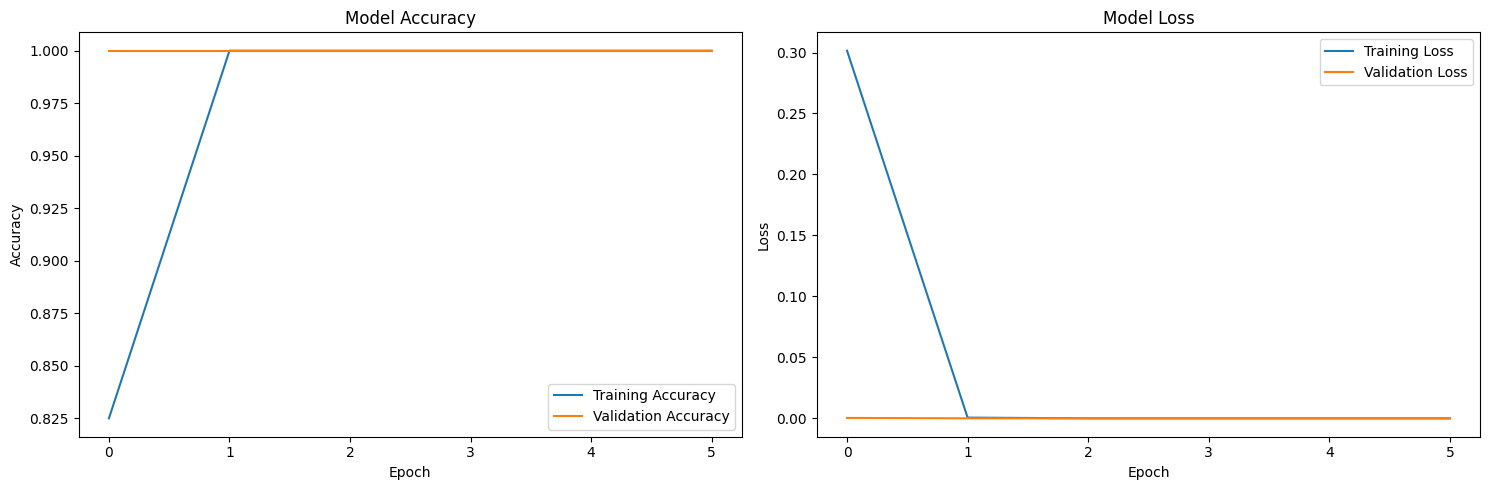

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - accuracy: 1.0000 - loss: 0.0155
Test loss: 0.0142
Test accuracy: 1.0000
Model saved successfully


In [12]:
def prepare_dataset(dataset_path, batch_size=32, augment=True):
    """Prepare dataset for training/testing"""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path does not exist: {dataset_path}")
    
    images = []
    labels = []
    
    # Define all possible classes
    all_classes = ['gun']  # Simplified for binary classification
    label_to_idx = {label: idx for idx, label in enumerate(all_classes)}
    
    # Get list of image files
    image_files = [f for f in os.listdir(dataset_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        raise ValueError(f"No images found in {dataset_path}")
    
    print(f"Found {len(image_files)} images in {dataset_path}")
    
    # Process images
    for image_file in image_files:
        try:
            # Load and preprocess image
            image_path = os.path.join(dataset_path, image_file)
            img = load_and_preprocess_image(image_path)
            
            # Extract label based on filename pattern
            if 'gun' in image_file.lower():
                label = 'gun'
            else:
                label = 'no_gun'  # Add this class if you have non-gun images
            
            if label in label_to_idx:
                images.append(img)
                labels.append(label_to_idx[label])
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue
    
    if not images:
        raise ValueError("No images were successfully processed")
    
    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    
    # Convert labels to categorical (one-hot encoding)
    categorical_labels = tf.keras.utils.to_categorical(labels, num_classes=len(all_classes))
    
    print(f"Processed {len(images)} images")
    print(f"Label mapping: {label_to_idx}")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {categorical_labels.shape}")
    
    return images, categorical_labels

def create_model(input_shape=(224, 224, 3), num_classes=1):  # Changed to binary classification
    """Create a CNN model for weapon detection"""
    # Base model - MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create new model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='sigmoid')  # Changed to sigmoid for binary classification
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
        loss='binary_crossentropy',  # Changed to binary crossentropy
        metrics=['accuracy']
    )
    
    return model

def main():
    try:
        # Create model directory if it doesn't exist
        os.makedirs(Config.MODEL_PATH, exist_ok=True)
        
        # Create and compile model
        model = create_model(num_classes=1)  # Binary classification
        print("Model created successfully")
        
        # Prepare data
        print("\nPreparing training data...")
        train_images, train_labels = prepare_dataset(Config.TRAIN_PATH)
        print("\nPreparing validation data...")
        val_images, val_labels = prepare_dataset(Config.VAL_PATH)
        print("\nPreparing test data...")
        test_images, test_labels = prepare_dataset(Config.TEST_PATH)
        
        # Verify shapes before training
        print("\nFinal verification of shapes:")
        print(f"Train - Images: {train_images.shape}, Labels: {train_labels.shape}")
        print(f"Val   - Images: {val_images.shape}, Labels: {val_labels.shape}")
        print(f"Test  - Images: {test_images.shape}, Labels: {test_labels.shape}")
        
        # Train model
        history = train_model(
            model=model,
            train_data=(train_images, train_labels),
            val_data=(val_images, val_labels)
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        evaluate_model(model, (test_images, test_labels))
        
        # Save final model
        model.save(os.path.join(Config.MODEL_PATH, 'final_model.keras'))
        print("Model saved successfully")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()